# Lab2- Point-of-Interest Recommendation Systems
## Urban Computing course - Leiden University
#### Instructor: Dr. Mitra Baratchi
#### Contributor: Hossein A. Rahmani





## Outline

1.   Recommender systems and Context information
2.   General Structure of Location-Based Social Network's Dataset
3.   Loading the dataset (Foursquare)
4.   Data Pre-processing
5.   Matrix Factorization
6.   Model Evaluation
7.   Utilizing Contextual Information: Geographical Model

## Recommender Systems

A recommender system is a simple algorithm with the aim to provide the most relevant recommendation to a user by discovering patterns in a dataset. Actually, recommender systems are a subclass of **information filtering system** addressing the problem of infromation overload. An example of a recommendation system in action is when you visit Amazon website and you notice that some items are being recommended to you or when Netflix recommends certain movies to you. One of the most important application of recommender systems is in Location-Based Social Networks (LBSNs) to recommend unvisited location to the users.

### Recommender system approaches

Recommender System approaches are generaly divided into three categories:

- **Collaborative Filtering (CF)**: CF is a method of recommending items to users using their past behaviors or ratings as well as similar decisions by other users to predict which items might be appealing to the original customers. The CF method divides into two subcategories, Memory-based and Model-based. In memory-based we use the whole of the user-item matrix to make the recommendation but in model-based we make use of machine learning approaches that are scalable and more efficient.

- **Content Based (CB)**: CB suggests items to users by using the characteristics of an item in order to recommend additional items with similar properties.

- **Hybrid Method**: A number of applications combine the CF and the CB algorithms. These overcome the limitations of native CF and CB approaches and improve prediction performance. Importantly, they overcome the CF problems such as sparsity and loss of information. 

Collaborative filtering is also much more popular for web-based recommendations where the data is sparse, i.e., where there is a limited number of reviews by each user or for a particular item.

More information for study and comparsion can be find in the [Basics of Recommender Systems: Study of Location-Based Social Networks](https://github.com/rahmanidashti/LRSbasics).

### Context-Aware Recommender Systems

In many applications, such as recommending a vacation package, personalized content on a Web site, or a movie, it may not be sufficient to consider only users and items – it is also important to incorporate the **contextual information** into the recommendation process in order to recommend items to users in certain circumstances. For example, using the temporal context, a travel recommender system would provide a vacation recommendation in the winter that can be very different from the one in summer. Similarly, in the case of personalized content delivery on a Web site, it is important to determine what content needs to be delivered (recommended) to a customer and when. More specifically, on weekdays a user might prefer to read world news when she logs on in the morning and the stock market report in the evening, and on weekends to read movie reviews and do shopping. In addition, Geographical influence is an important contextual factor that distinguishes the location recommendation from traditional item recommendation, because the check-in behavior depends on locations’ geographical features. The users' behavior on location-based social networks shows they would like to visit nearby locations rather than the distant ones.

## LBSN's Dataset

The dataset of a LBSN generates by a popular feature that called __Check-in__. When a user check in a location, it shows the user's presence in that location. Generally, a check-in information include:

*   User
*   Location
*   Latitude and longitude of location
*   Check-in time

For example, a record of check-in is something like: **user_0, location_0, 1.372494548, 103.893714, 28-01-2019 14:17:15**



## Import the required module

In [0]:
import pandas as pd
import numpy as np
from numpy.linalg import norm
import scipy.sparse as sparse
from collections import defaultdict
import time
import math
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import folium

## Load the dataset
To access the dataset, we upload the preprocessed dataset of Gowalla LBSN into a Github repository. Here, we have four files that needed for this assignment: **size, train, test, and geo**. The _size_ file includes the number of users and location (or POIs), _train and test_ files stores the user's check-ins and the _geo_ file includes the geograpical information of each location. As we mention above, we load the dataset from github. This is a small version of Gowalla dataset, you can find the other ones and large-scale dataset (you can find them here: https://github.com/rahmanidashti/LBSNDatasets/) to evaluate the methods.

In [0]:
size = "https://raw.githubusercontent.com/rahmanidashti/LBSNDatasets/master/Gowalla/Gowalla_2/Gowalla_data_size.txt"
train = "https://raw.githubusercontent.com/rahmanidashti/LBSNDatasets/master/Gowalla/Gowalla_2/Gowalla_train.txt"
test = "https://raw.githubusercontent.com/rahmanidashti/LBSNDatasets/master/Gowalla/Gowalla_2/Gowalla_test.txt"
geo = "https://raw.githubusercontent.com/rahmanidashti/LBSNDatasets/master/Gowalla/Gowalla_2/Gowalla_poi_coos.txt"

In [0]:
size_header = ['users', 'locations']
size_data = pd.read_csv(size, sep='	', names=size_header)
for index, eachline in size_data.iterrows():
  n_users, n_locations = eachline['users'], eachline['locations']
print("The numebr of users is", n_users,"and the number of locations is", n_locations)

header = ['uid', 'lid', 'freq']
train_data = pd.read_csv(train, sep='	', names=header)
test_data = pd.read_csv(test, sep='	', names=header)

geo_header = ['lid', 'lat', 'lng']
poi_data = pd.read_csv(geo, sep='	', names=geo_header)

### Load the training data

In [0]:
def read_training_data():
  training_matrix = np.zeros((n_users, n_locations))
  sparse_training_matrix = sparse.dok_matrix((n_users, n_locations))
  for index, row in train_data.iterrows():
    uid, lid, freq = row['uid'], row['lid'], row['freq']
    uid, lid, freq = int(uid), int(lid), int(freq)
    training_matrix[uid, lid] = 1.0
    sparse_training_matrix[uid, lid] = freq
  return sparse_training_matrix, training_matrix

### Load the latitude and longitude of POIs

In [0]:
def read_poi_coos():
  poi_coos = {}
  for index, row in poi_data.iterrows():
    lid, lat, lng = row['lid'], row['lat'], row['lng']
    lid, lat, lng = int(lid), float(lat), float(lng)
    poi_coos[lid] = (lat, lng)
  return poi_coos

### Load the test data

A part of dataset should be considered as test datat to evalute the model performance. Here, we cosider the 20% recently check-ins as test set.

In [0]:
def read_ground_truth():
  ground_truth = defaultdict(set)
  for index, row in test_data.iterrows():
    uid, lid, _ = row['uid'], row['lid'], row['freq']
    uid, lid = int(uid), int(lid)
    ground_truth[uid].add(lid)
  return ground_truth

### Intialize the datasets

In [0]:
sparse_training_matrix, training_matrix = read_training_data()
ground_truth = read_ground_truth()
poi_coos = read_poi_coos()

## Collaborative Filtering
As we talk earlier, one of the most popular approaches in recommender systems is __Collaborative Filtering (CF)__. At the first, the main approach of CF was __user-based CF__ but after 2009 with the challenge of Netflix the __Matrix Factorization (MF)__ has been one of the most used __Model-based CF__ approaches. The user-based approach is good when the data is small but when you need scalability you should choose MF or the other model-based approaches. Hence, we first consider and implement the user-based CF to recommend the locations then we implement one of the MF-based approaches. Finally, we show the impact of context in RS and integrate one of the most important contextual factors in location recommendation to the MF model.

### User-Based Collaborative Filtering [1]
 A user-based system can also use machine-learning algorithms to group all users who have shown that they have the same tastes. The system builds neighborhoods of users who have similar profiles, purchase patterns, or rating patterns. If a person in a neighborhood buys and likes an item, the recommender system can recommend that item to everyone else in the neighborhood. Here, we used __cosine-based similarity__. The cosine-based approach defines the cosine-similarity between two users $x$ and $y$ as:
 
 $\operatorname {sim} (x,y)=\cos({\vec {x}},{\vec {y}})={\frac {{\vec {x}}\cdot {\vec {y}}}{||{\vec {x}}||\times ||{\vec {y}}||}}={\frac {\sum \limits _{i\in I_{xy}}r_{x,i}r_{y,i}}{{\sqrt {\sum \limits _{i\in I_{x}}r_{x,i}^{2}}}{\sqrt {\sum \limits _{i\in I_{y}}r_{y,i}^{2}}}}}$

In [0]:
class UserBasedCF(object):
  def __init__(self):
    self.rec_score = None
    self.epsilon = 1e-9
    
  def pre_compute_rec_scores(self, C):
    ctime = time.time()
    print("Training User-based Collaborative Filtering...", )

    sim = C.dot(C.T)
    norms = [norm(C[i]) for i in range(C.shape[0])]

    for i in range(C.shape[0]):
      sim[i][i] = 0.0
      for j in range(i+1, C.shape[0]):
        sim[i][j] = sim[i][j] / ((norms[i] * norms[j]) + self.epsilon)
        sim[j][i] = sim[i][j] / ((norms[i] * norms[j]) + self.epsilon)

    self.rec_score = sim.dot(C)
    print("Done. Elapsed time:", time.time() - ctime, "s")

  def predict(self, i, j):
    return self.rec_score[i][j]


## Evaluation process of recommendation (Precision and Recall)

In pattern recognition, information retrieval and binary classification, precision (also called positive predictive value) is the fraction of relevant instances among the retrieved instances, while recall (also known as sensitivity) is the fraction of relevant instances that have been retrieved over the total amount of relevant instances. Both precision and recall are therefore based on an understanding and measure of relevance. You can read more on [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall).

In [0]:
def precisionk(actual, predicted):
  return 1.0 * len(set(actual) & set(predicted)) / len(predicted)

In [0]:
def recallk(actual, predicted):
  return 1.0 * len(set(actual) & set(predicted)) / len(actual)

## Store the evaluation values

to store each method result based on each users we have define some global variables (as [list](https://docs.python.org/3/tutorial/datastructures.html#more-on-lists)) to store each user's precision and recall.

In [0]:
# precison and recall by user-based CF for each user
precision_UB, recall_UB = [], []
# precison and recall by Poisson Matrix Factorization Matrix Factorization for each user
precision_MF, recall_MF = [], []
# precison and recall by MF + Geographical Influence for each user
precision_MFG, recall_MFG = [], []

### Recommendation by User-based Collaborative Filtering

In [0]:
def ub_runer():
  top_k = 100
  
  # remove the last values from pre and rec
  del precision_UB[:]
  del recall_UB[:]
  
  U = UserBasedCF()
  
  # Compute the user-based CF
  U.pre_compute_rec_scores(training_matrix)
  
  all_uids = list(range(n_users))
  all_lids = list(range(n_locations))
  np.random.shuffle(all_uids)
  
  # calculate the prediction value for each user on different items
  for cnt, uid in enumerate(all_uids):   
    if uid in ground_truth:
      U_scores = [U.predict(uid, lid)
                  if training_matrix[uid, lid] == 0 else -1
                  for lid in all_lids]
      
      U_scores = np.array(U_scores)
      
      # sort the items based on their prediction value
      predicted = list(reversed(U_scores.argsort()))[:top_k]
      actual = ground_truth[uid]
      
      # compute each user's precision and recall
      precision_UB.append(precisionk(actual, predicted[:10]))     
      recall_UB.append(recallk(actual, predicted[:10]))
      
  print("pre@10:", np.mean(precision_UB), "rec@10:", np.mean(recall_UB))    

In [0]:
# Now, you can run the user-based CF
ub_runer()

Training User-based Collaborative Filtering...
Done. Elapsed time: 0.03346562385559082 s
pre@10: 0.04499999999999999 rec@10: 0.029128869480040422


## Matrix Factorization
One technique thats commonly used for this problem is to project the matrix of user-location-visits in to a low rank approximation, and then compute distances in that space. The idea is to take the original visit count matrix, and then reduce that down to two much smaller matrices that approximate the original when multiplied together. You can find more about MF in [quuxlbs blog post](http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/). Here, based on [2], we use a version of matrix factorization that called __Poisson Factor Model__, which defines a Poisson distribution on the frequency. 

### Matrix Factorization: Poisson Factor Model [2]

In [0]:
class PoissonFactorModel(object):
  def __init__(self, K=30, alpha=20.0, beta=0.2):
    self.K = K
    self.alpha = alpha
    self.beta = beta
    self.U, self.L = None, None

  def train(self, sparse_check_in_matrix, max_iters=50, learning_rate=1e-4):
    ctime = time.time()
    print("Training PFM...", )

    alpha = self.alpha
    beta = self.beta
    K = self.K

    F = sparse_check_in_matrix
    M, N = sparse_check_in_matrix.shape
    U = 0.5 * np.sqrt(np.random.gamma(alpha, beta, (M, K))) / K
    L = 0.5 * np.sqrt(np.random.gamma(alpha, beta, (N, K))) / K

    F = F.tocoo()
    entry_index = list(zip(F.row, F.col))

    F = F.tocsr()
    F_dok = F.todok()

    tau = 10
    last_loss = float('Inf')
    for iters in range(max_iters):
      F_Y = F_dok.copy()
      for i, j in entry_index:
        F_Y[i, j] = 1.0 * F_dok[i, j] / U[i].dot(L[j]) - 1
      F_Y = F_Y.tocsr()

      learning_rate_k = learning_rate * tau / (tau + iters)
      U += learning_rate_k * (F_Y.dot(L) + (alpha - 1) / U - 1 / beta)
      L += learning_rate_k * ((F_Y.T).dot(U) + (alpha - 1) / L - 1 / beta)

      loss = 0.0
      for i, j in entry_index:
        loss += (F_dok[i, j] - U[i].dot(L[j]))**2

      print('Iteration:', iters,  'loss:', loss)

      if loss > last_loss:
        print("Early termination.")
        break
        last_loss = loss

      print("Done. Elapsed time:", time.time() - ctime, "s")
      self.U, self.L = U, L

  def predict(self, uid, lid, sigmoid=False):
    if sigmoid:
      return 1.0 / (1 + math.exp(-self.U[uid].dot(self.L[lid])))
    return self.U[uid].dot(self.L[lid])

### Recommendation by the Matrix Factoriztion

In [0]:
def mf_runer():
  
  top_k = 100
  
  del precision_MF[:]
  del recall_MF[:]
  
  
  PFM = PoissonFactorModel(K=30, alpha=20.0, beta=0.2)
  PFM.train(sparse_training_matrix, max_iters=10, learning_rate=1e-4)
  
  all_uids = list(range(n_users))
  all_lids = list(range(n_locations))
  np.random.shuffle(all_uids)
    
  for cnt, uid in enumerate(all_uids):
    if (int(cnt) != 0 and int(cnt) % 100 == 0):
      print("Passed", int(cnt), "/", n_users, "by Precision@10 and Recall@10: ",  np.mean(precision_MF), "and", np.mean(recall_MF))
    if uid in ground_truth:
      overall_scores = [PFM.predict(uid, lid)
                        if training_matrix[uid, lid] == 0 else -1
                        for lid in all_lids]     
      
      overall_scores = np.array(overall_scores)

      predicted = list(reversed(overall_scores.argsort()))[:top_k]
      actual = ground_truth[uid]
      
      precision_MF.append(precisionk(actual, predicted[:10]))
      recall_MF.append(recallk(actual, predicted[:10]))
      
  print(">> Finally Precision@10:", np.mean(precision_MF), "Recall@10:", np.mean(recall_MF))

In [0]:
mf_runer()

Training PFM...
Iteration: 0 loss: 153799.45175969432
Done. Elapsed time: 0.6696276664733887 s
Iteration: 1 loss: 150385.9171274143
Done. Elapsed time: 1.2190895080566406 s
Iteration: 2 loss: 147671.79094306694
Done. Elapsed time: 1.7524895668029785 s
Iteration: 3 loss: 145448.7344969039
Done. Elapsed time: 2.385960340499878 s
Iteration: 4 loss: 143597.69815591417
Done. Elapsed time: 2.988093614578247 s
Iteration: 5 loss: 142039.24676720003
Done. Elapsed time: 3.6430504322052 s
Iteration: 6 loss: 140716.44911524843
Done. Elapsed time: 4.21532940864563 s
Iteration: 7 loss: 139586.75709665637
Done. Elapsed time: 4.8342108726501465 s
Iteration: 8 loss: 138617.4564168024
Done. Elapsed time: 5.395563125610352 s
Iteration: 9 loss: 137782.85700407912
Done. Elapsed time: 6.022050142288208 s
>> Finally Precision@10: 0.026000000000000002 Recall@10: 0.017281262241184488


## Context Information

One of the most important context information is Geographical information that shows the users' check-ins behavior. Geographical (or _spatial_) information allows us to focus recommendations on locations close to the user, keeping our recommendations relevant as a user travels. Users tend to check in around several centers, where the check-in locations follow a Gaussian distribution at each center as shown in the following for a typical user’s check-in behavior.

In [0]:
# which user's check-ins distribution want to show?
which_user = 0

locationlist = []
# get the locations that have been checked-in by which_user
for user_checkins in range(training_matrix.shape[0]):
  if user_checkins == which_user:
    locations = training_matrix[user_checkins].nonzero()
  break
  
for locs in locations:
  for loc in locs:
    lat, lng = poi_coos[loc]
    # Make a list with the coordinates of each location
    locationlist.append([lat, lng])

# Open a map and initialize it with the coordinates
map = folium.Map(location=locationlist[0], zoom_start=5)
# add to the map all different locations
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(map)
map

### Geographical Information: Multi-center Gaussian Model

Here, we consider the geographical influence based on the above idea. Then, we fused the geographical influence into our MF method to show the impact of contextual information.

#### Find the distance between to locations

In [0]:
def dist(loc1, loc2):
    lat1, long1 = loc1.lat, loc1.lng
    lat2, long2 = loc2.lat, loc2.lng
    if abs(lat1 - lat2) < 1e-6 and abs(long1 - long2) < 1e-6:
        return 0.0
    degrees_to_radians = math.pi/180.0
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) +
           math.cos(phi1)*math.cos(phi2))
    arc = math.acos(cos)
    earth_radius = 6371
    return arc * earth_radius

#### The geographical approach

In [0]:
class Location(object):
    def __init__(self, id, lat, lng, freq, center=-1):
        self.id = id
        self.lat = lat
        self.lng = lng
        self.freq = freq
        self.center = center


class Center(object):
    def __init__(self):
        self.locations = []
        self.total_freq = 0
        self.distribution = None
        self.mu = None
        self.cov = None
        self.lat = None
        self.lng = None

    def add(self, loc):
        self.locations.append(loc)
        self.total_freq += loc.freq

    def build_gaussian(self):
        coo_seq = []
        for loc in self.locations:
            for _ in range(int(loc.freq)):
                coo_seq.append(np.array([loc.lat, loc.lng]))
        coo_seq = np.array(coo_seq)
        self.mu = np.mean(coo_seq, axis=0)
        self.cov = np.cov(coo_seq.T)
        self.distribution = multivariate_normal(self.mu, self.cov, allow_singular=True)
        self.lat = self.mu[0]
        self.lng = self.mu[1]

    def pdf(self, x):
        return self.distribution.pdf(np.array([x.lat, x.lng]))


class MultiGaussianModel(object):
    def __init__(self, alpha=0.2, theta=0.02, dmax=15):
        self.alpha = alpha
        self.theta = theta
        self.dmax = dmax
        self.poi_coos = None
        self.center_list = None

    def build_user_check_in_profile(self, sparse_check_in_matrix):
        L = defaultdict(list)
        for (uid, lid), freq in sparse_check_in_matrix.items():
            lat, lng = self.poi_coos[lid]
            L[uid].append(Location(lid, lat, lng, freq))
        return L

    def discover_user_centers(self, Lu):
        center_min_freq = max(sum([loc.freq for loc in Lu]) * self.theta, 2)
        Lu.sort(key=lambda k: k.freq, reverse=True)
        center_list = []
        center_num = 0
        for i in range(len(Lu)):
            if Lu[i].center == -1:
                center_num += 1
                center = Center()
                center.add(Lu[i])
                Lu[i].center = center_num
                for j in range(i+1, len(Lu)):
                    if Lu[j].center == -1 and dist(Lu[i], Lu[j]) <= self.dmax:
                        Lu[j].center = center_num
                        center.add(Lu[j])
                if center.total_freq >= center_min_freq:
                    center_list.append(center)
        return center_list

    def multi_center_discovering(self, sparse_check_in_matrix, poi_coos):
        self.poi_coos = poi_coos
        L = self.build_user_check_in_profile(sparse_check_in_matrix)

        center_list = {}
        for uid in range(len(L)):
            center_list[uid] = self.discover_user_centers(L[uid])
            for cid in range(len(center_list[uid])):
                center_list[uid][cid].build_gaussian()
        self.center_list = center_list

    def predict(self, uid, lid):
        lat, lng = self.poi_coos[lid]
        l = Location(None, lat, lng, None)

        prob = 0.0
        if uid in self.center_list:
            all_center_freq = sum([cid.total_freq**self.alpha for cid in self.center_list[uid]])
            all_center_pdf = sum([cid.pdf(l) for cid in self.center_list[uid]])
            if not all_center_pdf == 0:
                for cu in self.center_list[uid]:
                    prob += (
                        1.0 / (dist(l, cu) + 1) *
                        (cu.total_freq**self.alpha) / all_center_freq *
                        cu.pdf(l) / all_center_pdf)
        return prob

### Run the Matrix Factorization with Multi-Center Geographical Model

In [0]:
def mfg_runer():
  
  top_k = 100
  
  del precision_MFG[:]
  del recall_MFG[:]
  
  PFM = PoissonFactorModel(K=30, alpha=20.0, beta=0.2)
  PFM.train(sparse_training_matrix, max_iters=10, learning_rate=1e-4)
  
  print("Starting Multi-Center Gaussian Model ...")
  MGM = MultiGaussianModel(alpha=0.2, theta=0.02, dmax=15)
  MGM.multi_center_discovering(sparse_training_matrix, poi_coos)
  print("Done Multi-Center Gaussian Model.")
  
  all_uids = list(range(n_users))
  all_lids = list(range(n_locations))
  np.random.shuffle(all_uids)
    
  for cnt, uid in enumerate(all_uids):
    if (int(cnt) != 0 and int(cnt) % 100 == 0):
      print("Passed", int(cnt), "/", n_users, "by Precision@10 and Recall@10: ",  np.mean(precision_MFG), "and", np.mean(recall_MFG))
    if uid in ground_truth:
      overall_scores = [PFM.predict(uid, lid) * MGM.predict(uid, lid)
                        if training_matrix[uid, lid] == 0 else -1
                        for lid in all_lids]     
      
      overall_scores = np.array(overall_scores)

      predicted = list(reversed(overall_scores.argsort()))[:top_k]
      actual = ground_truth[uid]
      
      precision_MFG.append(precisionk(actual, predicted[:10]))
      recall_MFG.append(recallk(actual, predicted[:10]))
      
  print(">> Finally Precision@10:", np.mean(precision_MFG), "Recall@10:", np.mean(recall_MFG))   

In [0]:
mfg_runer()

Training PFM...
Iteration: 0 loss: 153757.60936673867
Done. Elapsed time: 0.7166135311126709 s
Iteration: 1 loss: 150348.21803663936
Done. Elapsed time: 1.3320369720458984 s
Iteration: 2 loss: 147637.98088891056
Done. Elapsed time: 2.029306411743164 s
Iteration: 3 loss: 145418.41552457062
Done. Elapsed time: 2.591646432876587 s
Iteration: 4 loss: 143570.49632184845
Done. Elapsed time: 3.170954942703247 s
Iteration: 5 loss: 142014.8337982975
Done. Elapsed time: 3.765207052230835 s
Iteration: 6 loss: 140694.54098974064
Done. Elapsed time: 4.352580308914185 s
Iteration: 7 loss: 139567.10833538143
Done. Elapsed time: 4.9656853675842285 s
Iteration: 8 loss: 138599.8541545378
Done. Elapsed time: 5.638741970062256 s
Iteration: 9 loss: 137767.11577779058
Done. Elapsed time: 6.212277889251709 s
Starting Multi-Center Gaussian Model ...
Done Multi-Center Gaussian Model.
>> Finally Precision@10: 0.041999999999999996 Recall@10: 0.02693957780546271


## Expriment Comparsion

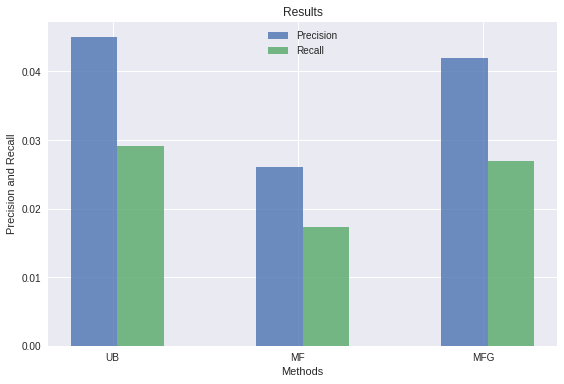

In [0]:
# data to plot
n_groups = 3
means_precision = (np.mean(precision_UB), np.mean(precision_MF), np.mean(precision_MFG))
means_recall = (np.mean(recall_UB), np.mean(recall_MF), np.mean(recall_MFG))

 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8
 
rects1 = plt.bar(index, means_precision, bar_width,
alpha=opacity,
label='Precision')
 
rects2 = plt.bar(index + bar_width, means_recall, bar_width,
alpha=opacity,
label='Recall')
 
plt.xlabel('Methods')
plt.ylabel('Precision and Recall')
plt.title('Results')
plt.xticks(index + 0.1, ('UB', 'MF', 'MFG'))
plt.legend()
 
plt.tight_layout()
plt.show()

### Significant results
To show the result is significant (i.e. there is a significant difference between the means of two groups) you can use the _t-Test_. When you want to compare your result with the other methods results, you should run _t-Test_ to show if the result is significant or not. Actually, you must run _t-Test_ for each result based on each metric. You can find more details in the following link and see how to use _t-Test_ in python with Scipy: [t-Test in Scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)

### Conclusion
As you can see in the plot, UB method outperforms the onther ones. The main reason is our datatset becasue _user-based_ use all of users and items information as it is a memory-based approach. Here, the dataset is very small, we just have 100 users. When, the users and items growth the MF approaches are better as they are scalable. Also, as MFG outperforms MF, you can see the impact of Context information to model the users' behavior.

## Acknowledge
For implemenation we got some information and useful review of the codes that provided by the following paper:  
__Liu, Yiding, et al. "An experimental evaluation of point-of-interest recommendation in location-based social networks." in VLDB, 2017__

## References

[1] __Ye, Mao, et al. "Exploiting geographical influence for collaborative point-of-interest recommendation" in SIGIR, 2011.__  
[2] __Cheng, Chen, et al. "Fused matrix factorization with geographical and social influence in location-based social networks", in AAAI, 2012.__